# XAI Laboratory 01 - Tabular Methods

For this practice, you will need the following dataset:

- **fifa**: regression dataset containing FIFA players data:
    - short_name: name of the player
    - nationality
    - overall: overall score of the player (potential output)
    - potential: potential score of the player (potential output)
    - wage_eur: contract cancellation fine of the player (potential output)
    - value_eur: value in euros of the player (potential output)
    - age: age of the player in years
    - height_cm: height of the player in cm
    - weight_kg: weight of the player in kg
    - attacking_skills: several variables related to attacking
    - defending_skills: several variables related to defending
    - goalkeeping_skills: several variables related to goalkeeping

Use what you have learned from the `tabular_explanation.ipynb` notebook to complete the questions.

In [1]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# XAI
import shap
import lime
from alepython import ale_plot # You might need to install from source: pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

np.random.seed(2025)

c:\Users\peper\OneDrive - Universidad Pontificia Comillas\Documentos\IMAT\5\explicabilidad\p1-tabular-methods-pepert03\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Load file --------------------------------------------
df = pd.read_csv('../data/fifa.csv')
df.head()

,short_name,nationality,overall,potential,wage_eur,value_eur,age,height_cm,weight_kg,attacking_crossing,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,L. Messi,Argentina,94,94,565000,95500000,32,170,72,88,...,75,96,33,37,26,6,11,15,14,8
1,Cristiano Ronaldo,Portugal,93,93,405000,58500000,34,187,83,84,...,85,95,28,32,24,7,11,15,14,11
2,Neymar Jr,Brazil,92,92,290000,105500000,27,175,68,87,...,90,94,27,26,29,9,9,15,15,11
3,J. Oblak,Slovenia,91,93,125000,77500000,26,188,87,13,...,11,68,27,12,18,87,92,78,90,89
4,E. Hazard,Belgium,91,91,470000,90000000,28,175,74,81,...,88,91,34,27,22,11,12,6,8,8


In [3]:
X = df.drop(["short_name", "nationality", "overall", "potential", "value_eur", "wage_eur"], axis = 1)
y = df['value_eur']

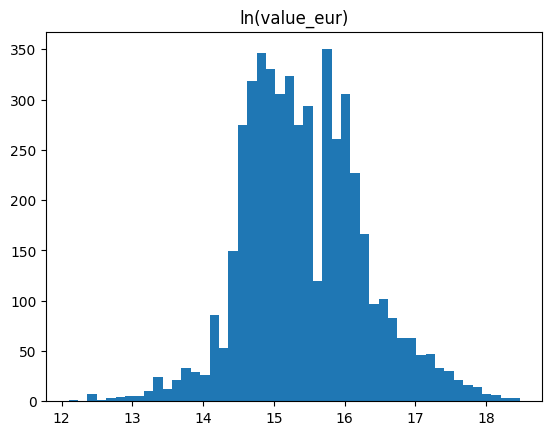

In [4]:
# Change scale of output variable
ylog = np.log(y)

plt.hist(ylog, bins='auto')
plt.title("ln(value_eur)")
plt.show()

In [5]:
X_train, X_test, ylog_train, ylog_test, y_train, y_test = train_test_split(X, ylog, y, test_size=0.25, random_state=42)

In [6]:
# Train XGBoost model, may take a few minutes
model = XGBRegressor()
model.fit(X_train, ylog_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [7]:
def predict_function(model, data):
    """Predict wrapper: original model was trained on log-output; return exp(pred) to recover original scale."""
    return np.exp(model.predict(data))

---
Ex 1. Ensure your model is not overfitted

In [8]:
from sklearn.metrics import mean_squared_error

y_pred_train = predict_function(model, X_train)
y_pred_test = predict_function(model, X_test)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

print(f"Train RMSE: {rmse_train:.3f}, Test RMSE: {rmse_test:.3f}")

Train RMSE: 317968.089, Test RMSE: 3097290.609


---
Ex 2. Obtain and plot variable importance measures using the following variable groups

In [9]:
variable_groups = {
    'age': ['age'],
    'body': ['height_cm', 'weight_kg'],
    'attacking': ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys'],
    'skill': ['skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control'],
    'movement': ['movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance'],
    'power': ['power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots'],
    'mentality': ['mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties',
        'mentality_composure'],
    'defending': ['defending_marking', 'defending_standing_tackle','defending_sliding_tackle'],
    'goalkeeping' : ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']
}

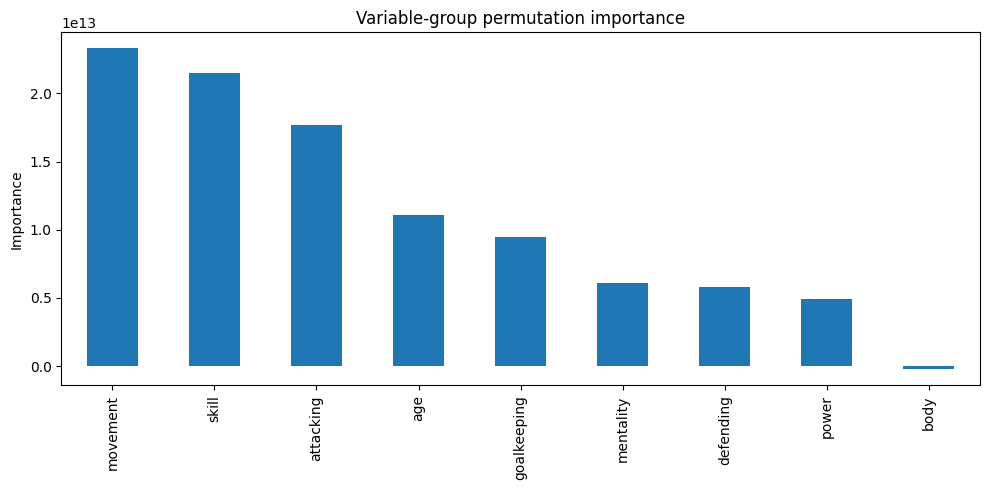

In [10]:
from sklearn.inspection import permutation_importance
class EstimatorWrapper:
    def __init__(self, model):
        self.model = model
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return predict_function(self.model, X)

wrapper = EstimatorWrapper(model)
perm_res = permutation_importance(wrapper, X_test, y_test, n_repeats=10, random_state=42, scoring='neg_mean_squared_error')
feat_names = X.columns.tolist()
feat_importances = pd.DataFrame({
    'feature': feat_names,
    'importance': perm_res.importances_mean
}).sort_values('importance', ascending=False)

group_importances = {}
for gname, feats in variable_groups.items():
    group_importances[gname] = feat_importances.set_index('feature').reindex(feats).importance.fillna(0).sum()
gseries = pd.Series(group_importances).sort_values(ascending=False)


# Grafica importancia por grupo
plt.figure(figsize=(10,5))
gseries.plot(kind='bar')
plt.title('Variable-group permutation importance')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

---
Ex 3. Obtain which is the variable with higher influence in Leo Messi's value. Justify which algorithm you choose

PermutationExplainer explainer: 2it [00:28, 28.39s/it]               



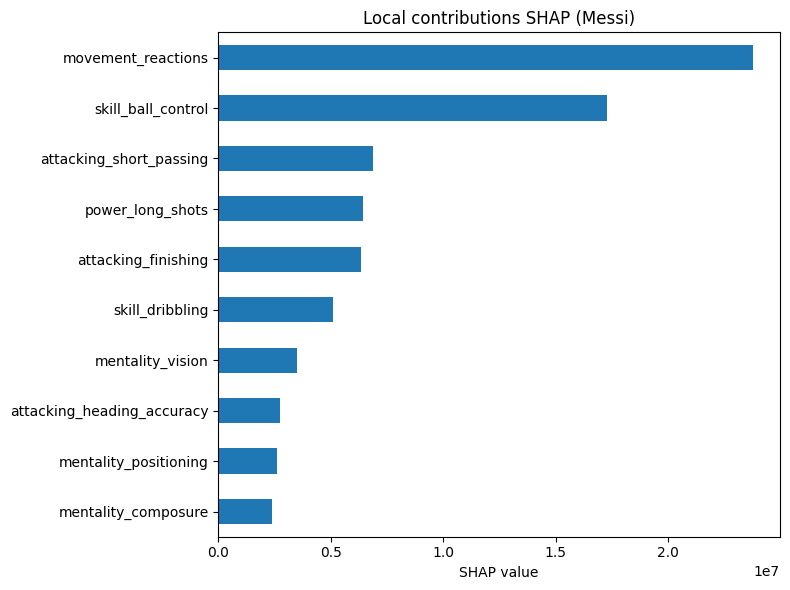

In [11]:

messi = X.loc[[df[df['short_name'].str.contains('messi', case=False, na=False)].index[0]]]


bg_size = min(200, len(X_train))
bg = X_train.sample(n=bg_size, random_state=42)
predict_fn = lambda X_in: predict_function(model, pd.DataFrame(X_in, columns=X.columns))
explainer = shap.Explainer(predict_fn, bg, feature_names=X.columns)

sv = explainer(messi)
shap_values = sv.values[0]
contribs = pd.Series(shap_values, index=X.columns)
top_abs = contribs.abs().sort_values(ascending=False).head(10).index

# Gráfico ordenado
top_contribs = contribs[top_abs].sort_values()
plt.figure(figsize=(8,6))
top_contribs.plot(kind='barh')
plt.title('Local contributions SHAP (Messi)')
plt.xlabel('SHAP value')
plt.tight_layout()
plt.show()


>>> I chose SHAP because the model is a tree type, and SHAP is perfect for that. It breaks down the prediction into contributions per feature, which sum to the difference between the prediction and the model's expected value.

---
Ex 4. Explain how perturbating the `height_cm` variable affect the value of Cristiano Ronaldo

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


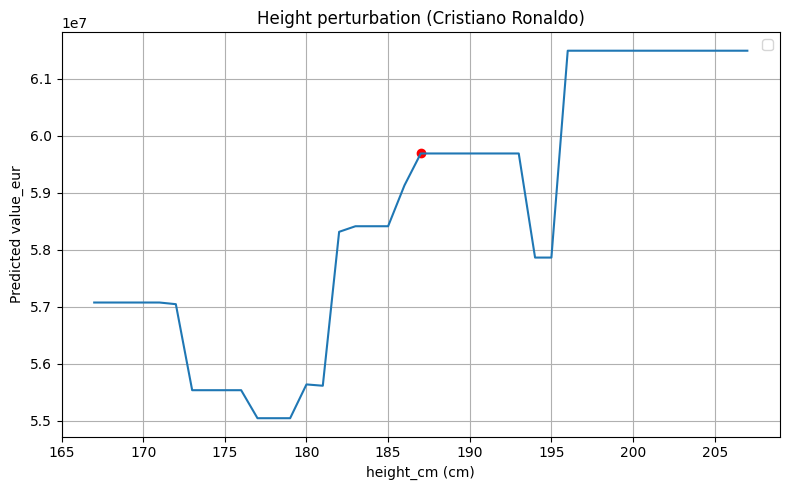

In [12]:
import numpy as np

idx = df[df['short_name'].str.contains('ronaldo', case=False, na=False)].index[0]
ronaldo = X.loc[[idx]].copy()
true_value = y.loc[idx]
current_height = float(ronaldo.iloc[0]['height_cm'])
h_min = max(120, current_height - 20)
h_max = current_height + 20
heights = np.linspace(h_min, h_max, 41)

preds = []
for h in heights:
    tmp = ronaldo.copy()
    tmp['height_cm'] = h
    preds.append(predict_function(model, tmp)[0])

preds = np.array(preds)

# Plot: predicción vs altura perturbada
plt.figure(figsize=(8,5))
plt.plot(heights, preds)
plt.scatter([current_height], [predict_function(model, ronaldo)[0]], color='r')
plt.xlabel('height_cm (cm)')
plt.ylabel('Predicted value_eur')
plt.title('Height perturbation (Cristiano Ronaldo)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


>>> The global PDP allows us to see the influence of `height_cm` (averaging the interaction with other variables) by seeing how the prediction would change according to height


---
Ex 5. Explain the average effect of the `age` variable on the model predictions. Does it differ greatly along the samples in the dataset? Which should be more affected by perturbating this variable, the goalkeepers or the strikers?

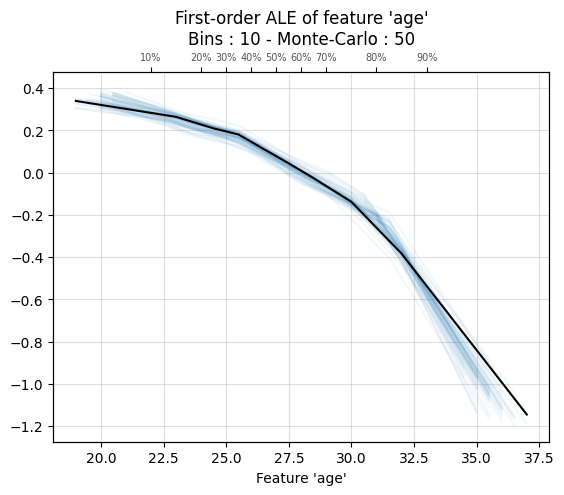

<Axes: title={'center': "First-order ALE of feature 'age'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'age'">

In [13]:
ale_plot(model, X_train, 'age', monte_carlo=True)

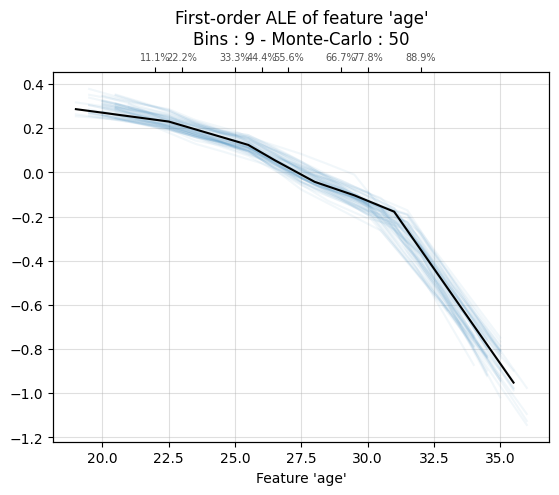

ALE Plot of Age for Attackers


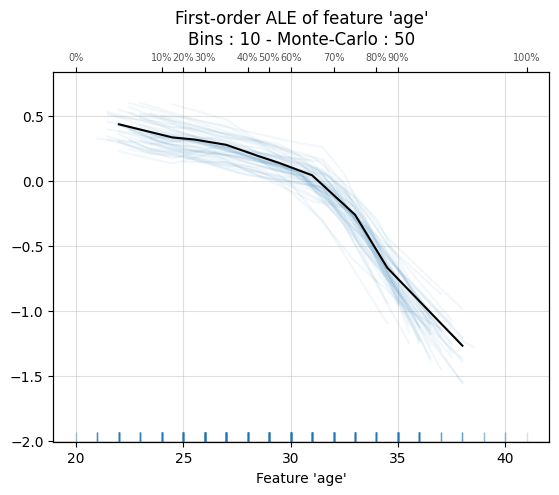

ALE Plot of Age for Goalkeepers


In [19]:
# Clasificación simple de jugadores por tipo (Attacker / Defender / Goalkeeper)

df['attacker_score'] = df[['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys']].mean(axis=1)
df['goalkeeper_score'] = df[['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']].mean(axis=1)
df['defender_score'] = df[['defending_marking', 'defending_standing_tackle', 'defending_sliding_tackle']].mean(axis=1)

def classify_role(row):
    scores = {
        'Attacker': row['attacker_score'],
        'Defender': row['defender_score'],
        'Goalkeeper': row['goalkeeper_score']
    }
    return max(scores, key=scores.get)

# ahora hacemos el ale de cada uno
df['role'] = df.apply(classify_role, axis=1)
for role in ['Attacker', 'Goalkeeper']:
    subset = X_train[df['role'].loc[X_train.index] == role]
    if len(subset) > 0:
        ale_plot(model, subset, 'age', monte_carlo=True)
        print(f'ALE Plot of Age for {role}s')
        plt.show()
        

>>> Age affects pretty similarly the predictions of both roles. However, strikers seem to be slightly more affected by changes in age compared to goalkeepers, as their performance tends to decline more rapidly after reaching their peak age.

Ex 6. Explain the prediction made for Hazard using a local surrogate model (Lime)

In [ ]:
from lime.lime_tabular import LimeTabularExplainer
idx = df[df['short_name'].str.contains('hazard', case=False, na=False)].index[0]
hazard = X.loc[[idx]]
explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns.tolist(),
    mode='regression'
)
exp = explainer.explain_instance(
    data_row=hazard.iloc[0].values,
    predict_fn=lambda x: predict_function(model, pd.DataFrame(x, columns=X.columns)),
    num_features=10
)
exp.show_in_notebook(show_table=True)

>>> Movement reactions have the best influence on the prediction for Hazard.